### Set GPU clocks

In [ ]:
!sudo nvidia-persistenced
!sudo nvidia-smi -ac 877,1530

In [1]:
from utils import *
from torch_backend import Batches, Network
#from mxnet_backend import Batches, Network

### Network definition

In [2]:
def conv_bn(c_in, c_out):
    return {
        'conv': Conv2d(c_in, c_out, (3, 3), stride=1, padding=1, bias=False), 
        'bn': BatchNorm2d(c_out), 
        'relu': ReLU(),
    }

def residual(c):
    return {
        'in': Identity(),
        'res1': conv_bn(c, c),
        'res2': conv_bn(c, c),
        'add': (Add(), [rel_path('in'), rel_path('res2', 'relu')]),
    }

def basic_net(channels, weight,  pool):
    return {
        'prep': conv_bn(3, channels['prep']),
        'layer1': dict(conv_bn(channels['prep'], channels['layer1']), pool=pool),
        'layer2': dict(conv_bn(channels['layer1'], channels['layer2']), pool=pool),
        'layer3': dict(conv_bn(channels['layer2'], channels['layer3']), pool=pool),
        'pool': MaxPool2d(4),
        'flatten': Flatten(),
        'linear': Linear(channels['layer3'], 10, bias=False),
        'classifier': Mul(weight),
    }

def net(channels=None, weight=0.125, pool=MaxPool2d(2), extra_layers=(), res_layers=('layer1', 'layer3')):
    channels = channels or {'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512}
    n = basic_net(channels, weight, pool)
    for layer in res_layers:
        n[layer]['residual'] = residual(channels[layer])
    for layer in extra_layers:
        n[layer]['extra'] = conv_bn(channels[layer], channels[layer])       
    return n

losses = {
    'loss':  (CrossEntropyLoss(reduction='sum'), [('classifier',), ('target',)]),
    'correct': (Correct(), [('classifier',), ('target',)]),
}

### Download and preprocess data

In [5]:
DATA_DIR = './data'
data, targets = get_cifar10(DATA_DIR)

t = Timer()
print('Preprocessing training data')
train_set = list(zip(transpose(normalise(pad(data['train'], 4))), targets['train']))
print(f'Finished in {t():.2} seconds')
print('Preprocessing test data')
test_set = list(zip(transpose(normalise(data['test'])), targets['test']))
print(f'Finished in {t():.2} seconds')

Using already downloaded file: ./data/cifar-10-python.tar.gz
Preprocessing training data
Finished in 4.0 seconds
Preprocessing test data
Finished in 0.19 seconds


### Network visualisation

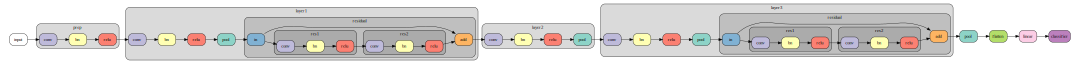

In [3]:
display(DotGraph(net()))

### Training

NB: on the first run, the first epoch will be slower as initialisation and Cudnn benchmarking take place.

In [ ]:
epochs=24
lr_schedule = PiecewiseLinear([0, 5, epochs], [0, 0.4, 0])
batch_size = 512
cutout=8
N_runs = 5

train_batches = Batches(Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(cutout, cutout)]), batch_size, 
                        shuffle=True, set_random_choices=True, num_workers=0, drop_last=True)
test_batches = Batches(test_set, batch_size, shuffle=False, num_workers=0)

opt_params = [(lr_schedule(x)/batch_size, 5e-4*batch_size, 0.9) for 
                  x in np.arange(0, epochs, 1/len(train_batches))]
network = union(net(), losses)

test_accs = []
for i in range(N_runs):
    print(f'Starting Run {i} at {localtime()}')
    timer, table = Timer(), TableLogger()
    model = Network(network).load_weights(initial_weights(network)).half()
    optimizer = Nesterov(model.trainable_params(), params=opt_params)
    for epoch in range(1, epochs+1):
        epoch_stats = train_epoch(model, train_batches, test_batches, optimizer.step, timer, test_time_in_total=True) 
        table.append(union({'epoch': epoch, 'lr': lr_schedule(epoch)}, epoch_stats))  
    test_accs.append(epoch_stats['test acc'])

print(f'mean test accuracy: {np.mean(test_accs):.4f}')
print(f'median test accuracy: {np.median(test_accs):.4f}')
print(f'{np.sum([x>=0.94 for x in test_accs])}/{N_runs} >= 94%')